<a href="https://colab.research.google.com/github/iBakeHoNey/Thesis22-23/blob/main/Secant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install filterpy

In [2]:
import numpy as np
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [3]:
def transp(time, x, u):
    # Medium-sized transport aircraft, longitudinal dynamics.
    S = 2170.0; CBAR = 17.5; MASS = 5.0E3; IYY = 4.1E6;
    TSTAT = 6.0E4; DTDV = -38.0; ZE = 2.0;  CDCLS = 0.042;
    CLA = 0.085; CMA = -0.022; CMDE = -0.016;     # per degree
    CMQ = -16.0; CMADOT = -6.0; CLADOT = 0.0;     # per radian
    RTOD = 57.29578; GD = 32.17;

    THTL = u[0]
    ELEV = u[1]
    XCG = u[2]
    LAND = u[3]

    VT = x[0]             # True airspeed in fps
    ALPHA = RTOD * x[1]   # AOA
    THETA = x[2]          # Pitch Rate
    Q = x[3]              # Pitch Altitude
    H = x[4]              # Altitude

    T, RHO, MACH, QBAR, PS = ADC(VT, H)
    QS = QBAR * S
    SALP = np.sin(x[1]); CALP = np.cos(x[1])
    GAM = THETA - x[1]
    SGAM = np.sin(GAM); CGAM = np.cos(GAM)

    if LAND == 0:
        CLO = 0.20; CDO = 0.016;
        CMO = 0.05; DCDG = 0.0; DCMG = 0.0
    elif LAND == 1:
        CLO = 1.0; CDO = 0.08;
        CMO = -0.20; DCDG = 0.02; DCMG = -0.05
    #else:
        #raise ValueError('Landing Gear & Flaps?')

    THR = (TSTAT + VT * DTDV) * max(THTL, 0)                          # Thrust
    CL = CLO + CLA * ALPHA                                            # Lift
    CM = DCMG + CMO + CMA * ALPHA + CMDE * ELEV + CL * (XCG - 0.25)   # Moment
    CD = DCDG + CDO + CDCLS * CL * CL                                 # Drag

    # State Equations
    xd = np.zeros(5)
    xd[0] = (THR * CALP - QS * CD) / MASS - GD * SGAM
    xd[1] = (-THR * SALP - QS * CL + MASS * (VT * Q + GD * CGAM)) / (MASS * VT + QS * CLADOT)
    xd[2] = Q
    D = 0.5 * CBAR * (CMQ * Q + CMADOT * xd[1]) / VT
    xd[3] = (QS * CBAR * (CM + D) + THR * ZE) / IYY
    xd[4] = VT * SGAM

    return xd, CD, CL, CM

In [4]:
def ADC(VT, ALT):
    R0 = 2.377E-3                 # Sea-level density
    TFAC = 1.0 - 0.703E-5 * ALT
    T = 519.0 * TFAC              # Temperature
    if ALT >= 35000.0:
        T = 390.0
    RHO = R0 * (TFAC**4.14)       # Density
    AMACH = VT / np.sqrt(1.4 * 1716.3 * T)  # Mach no.
    QBAR = 0.5 * RHO * VT**2      # Dynamic Pressure
    PS = 1715.0 * RHO * T         # Static Pressure

    return T, RHO, AMACH, QBAR, PS

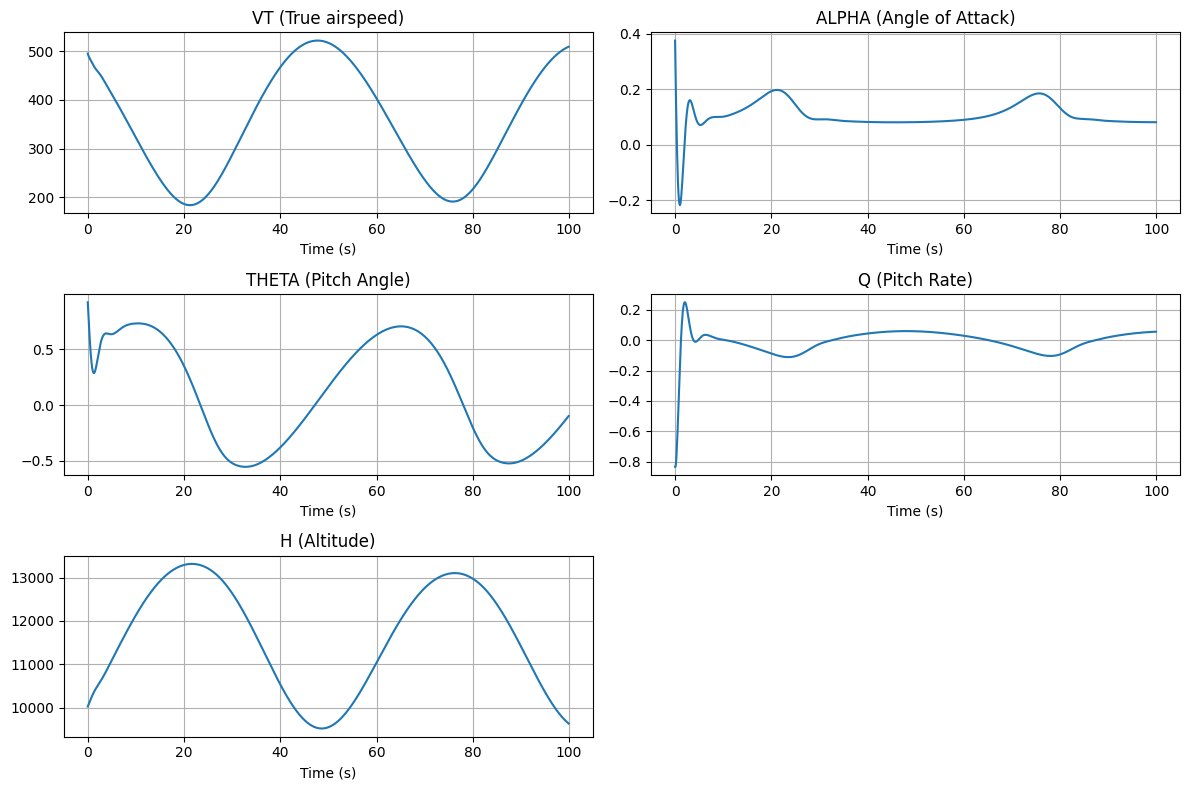

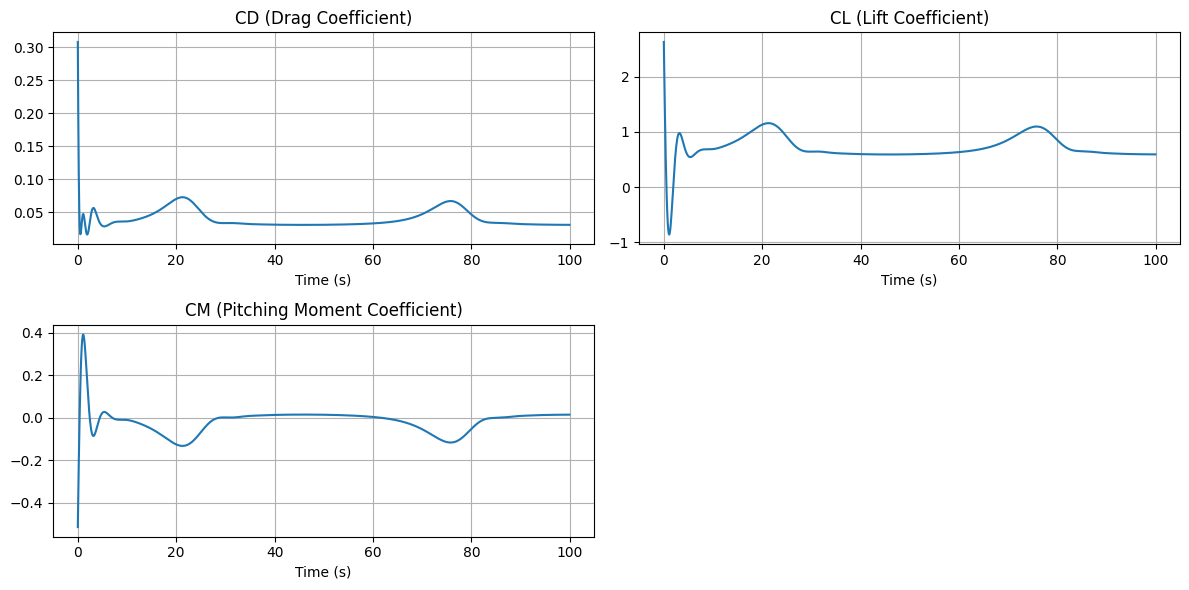

In [5]:
# Simulation settings
duration = 100.0
dt = 0.1
num_steps = int(duration/dt)
time_array = np.arange(0, duration, dt)

# Initial conditions
x = np.array([500.0, 0.5, 1, -0.8, 10000])  # [VT, ALPHA, THETA, Q, H]
u = np.array([0.204, -4.1, 0.25, 0])  # [THTL, ELEV, XCG, LAND]

# Storing history for plotting or analysis
x_history = np.zeros((num_steps, len(x)))
CD_history = np.zeros(num_steps)
CL_history = np.zeros(num_steps)
CM_history = np.zeros(num_steps)
estimated_alpha = np.zeros(num_steps)

for step in range(num_steps):
    xd, CD, CL, CM = transp(step*dt, x, u)

    # Euler integration step
    x = x + xd * dt
    CD_history[step] = CD
    CL_history[step] = CL
    CM_history[step] = CM

    # Store state for future reference or plotting
    x_history[step, :] = x

# Plotting the states
time_array = np.arange(0, duration, dt)
state_names = ['VT (True airspeed)', 'ALPHA (Angle of Attack)', 'THETA (Pitch Angle)', 'Q (Pitch Rate)', 'H (Altitude)']

plt.figure(figsize=(12, 8))
for i, name in enumerate(state_names):
    plt.subplot(3, 2, i+1)
    plt.plot(time_array, x_history[:, i])
    plt.title(name)
    plt.xlabel('Time (s)')
    plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting CD, CL, CM values
coeff_names = ['CD (Drag Coefficient)', 'CL (Lift Coefficient)', 'CM (Pitching Moment Coefficient)']
coeff_values = [CD_history, CL_history, CM_history]

plt.figure(figsize=(12, 6))
for i, name in enumerate(coeff_names):
    plt.subplot(2, 2, i+1)
    plt.plot(time_array, coeff_values[i])
    plt.title(name)
    plt.xlabel('Time (s)')
    plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
true_alpha = x_history[:, 1]

# Mean Squared Error
MSE = np.mean((true_alpha - estimated_alpha) ** 2)

# Mean Absolute Error
MAE = np.mean(np.abs(true_alpha - estimated_alpha))

print(f"Mean Squared Error (MSE): {MSE}")
print(f"Mean Absolute Error (MAE): {MAE}")

Mean Squared Error (MSE): 0.01334817815619149
Mean Absolute Error (MAE): 0.10943831263647498


In [7]:
x_history[2,1]
CL_history[1]

2.0274215152186486

In [8]:
def estimate_AOA_secant(target_CL, initial_AOA1, initial_AOA2, x, u, max_iter=100, tol=1e-6):
    AOA_n_minus_1 = initial_AOA1
    AOA_n = initial_AOA2

    for _ in range(max_iter):
        x_temp_minus_1 = x.copy()
        x_temp_minus_1[1] = AOA_n_minus_1
        _, _, CL_n_minus_1, _ = transp(0, x_temp_minus_1, u)

        x_temp = x.copy()
        x_temp[1] = AOA_n
        _, _, CL_n, _ = transp(0, x_temp, u)

        # Secant formula for root estimation
        AOA_n_plus_1 = AOA_n - (CL_n - target_CL) * (AOA_n - AOA_n_minus_1) / (CL_n - CL_n_minus_1)

        if abs(AOA_n_plus_1 - AOA_n) < tol:
            return AOA_n_plus_1

        AOA_n_minus_1 = AOA_n
        AOA_n = AOA_n_plus_1

    return AOA_n

# Test
target_CL_value = 0.5  # Replace with the desired CL value
initial_guess_AOA1 = 0.1
initial_guess_AOA2 = -0.1
estimated_AOA = estimate_AOA_secant(target_CL_value, initial_guess_AOA1, initial_guess_AOA2, x, u)
print(f"Estimated AOA: {estimated_AOA}")

Estimated AOA: 0.06159985542924595


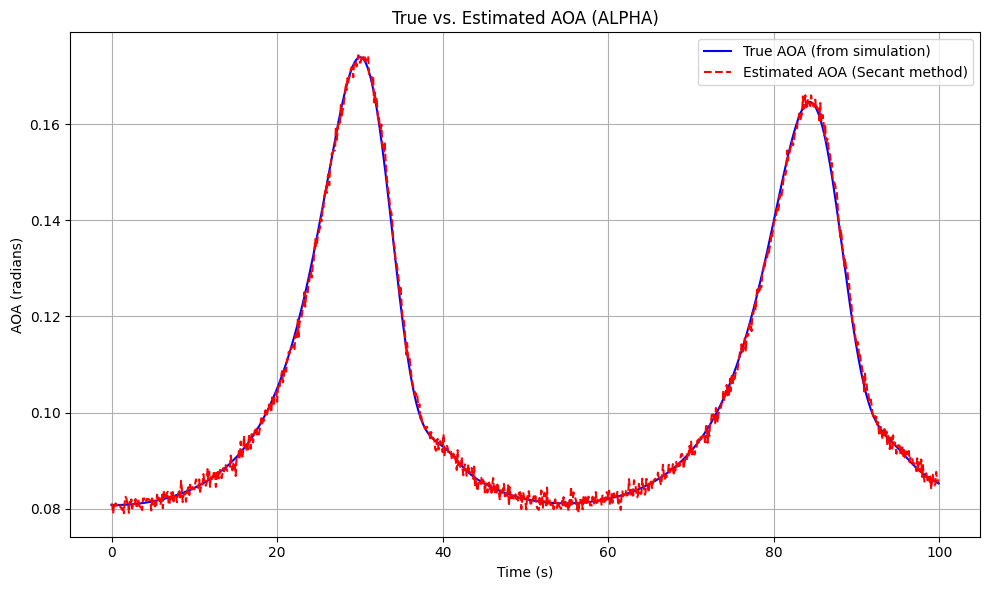

In [9]:
# Storing history for plotting or analysis
x_history = np.zeros((num_steps, len(x)))
CD_history = np.zeros(num_steps)
CL_history = np.zeros(num_steps)
CM_history = np.zeros(num_steps)

for step in range(num_steps):
    xd, CD, CL, CM = transp(step*dt, x, u)

    # Euler integration step
    x = x + xd * dt
    CD_history[step] = CD
    CL_history[step] = CL
    CM_history[step] = CM

    # Store state for future reference or plotting
    x_history[step, :] = x

# Now, let's calculate the estimated AOA using the Secant method for each time step
estimated_AOA_history = np.zeros(num_steps)

# Parameters for Gaussian noise
noise_mean = 0
noise_std_dev = 0.001  # Adjust this value based on how much noise you want

for step in range(num_steps):
    estimated_AOA = estimate_AOA_secant(CL_history[step], initial_guess_AOA1, initial_guess_AOA2, x_history[step, :], u)
    noise = np.random.normal(noise_mean, noise_std_dev)
    estimated_AOA_history[step] = estimated_AOA + noise

# Plotting the true AOA against the estimated AOA
plt.figure(figsize=(10, 6))
plt.plot(time_array, x_history[:, 1], label='True AOA (from simulation)', color='blue')  # Multiplied by 57.29578 to convert radians to degrees
plt.plot(time_array, estimated_AOA_history, '--', label='Estimated AOA (Secant method)', color='red')
plt.title('True vs. Estimated AOA (ALPHA)')
plt.xlabel('Time (s)')
plt.ylabel('AOA (radians)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
# Calculating the errors
errors = x_history[:, 1] - estimated_AOA_history
# Mean Absolute Error (MAE)
mae = np.mean(np.abs(errors))
# Root Mean Square Error (RMSE)
rmse = np.sqrt(np.mean(errors**2))
# Mean Bias Deviation (MBD)
mbd = np.sum(errors) / np.sum(np.abs(errors)) * 100
# Standard Deviation of the Error (STDE)
stde = np.std(errors)
# Mean Percentage Error (MPE)
mpe = np.mean(errors / (x_history[:, 1] * 57.29578) * 100)

# Displaying the calculated metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Square Error (RMSE): {rmse}")
print(f"Mean Bias Deviation (MBD): {mbd}%")
print(f"Standard Deviation of the Error (STDE): {stde}")
print(f"Mean Percentage Error (MPE): {mpe}%")


Mean Absolute Error (MAE): 0.0009528019115666302
Root Mean Square Error (RMSE): 0.0012060291811630058
Mean Bias Deviation (MBD): -3.506266481327363%
Standard Deviation of the Error (STDE): 0.0012055663840905453
Mean Percentage Error (MPE): -0.0005151977546704856%


In [11]:
def ADC(VT, ALT):
    R0 = 2.377E-3
    TFAC = 1.0 - 0.703E-5 * ALT
    T = np.where(ALT >= 35000.0, 390.0, 519.0 * TFAC)  # Use np.where to handle arrays
    RHO = R0 * (TFAC**4.14)
    return RHO  # Return the values as needed

# Variables from the provided transp function:
S = 2170.0
CLO = 0.20; CDO = 0.016; CLA = 0.085; CDCLS = 0.042; DCDG = 0.0

# Using the true angle of attack values:
CL_true = CLO + CLA * true_alpha
CD_true = DCDG + CDO + CDCLS * CL_true * CL_true

# Using the estimated angle of attack values:
CL_estimated = CLO + CLA * estimated_AOA_history
CD_estimated = DCDG + CDO + CDCLS * CL_estimated * CL_estimated

# Compute density using the ADC function:
RHO = ADC(x_history[:, 0], x_history[:, 4])

# Compute the true and estimated lift and drag forces:
Lift_true = 0.5 * RHO * x_history[:, 0]**2 * S * CL_true
Drag_true = 0.5 * RHO * x_history[:, 0]**2 * S * CD_true
Lift_estimated = 0.5 * RHO * x_history[:, 0]**2 * S * CL_estimated
Drag_estimated = 0.5 * RHO * x_history[:, 0]**2 * S * CD_estimated


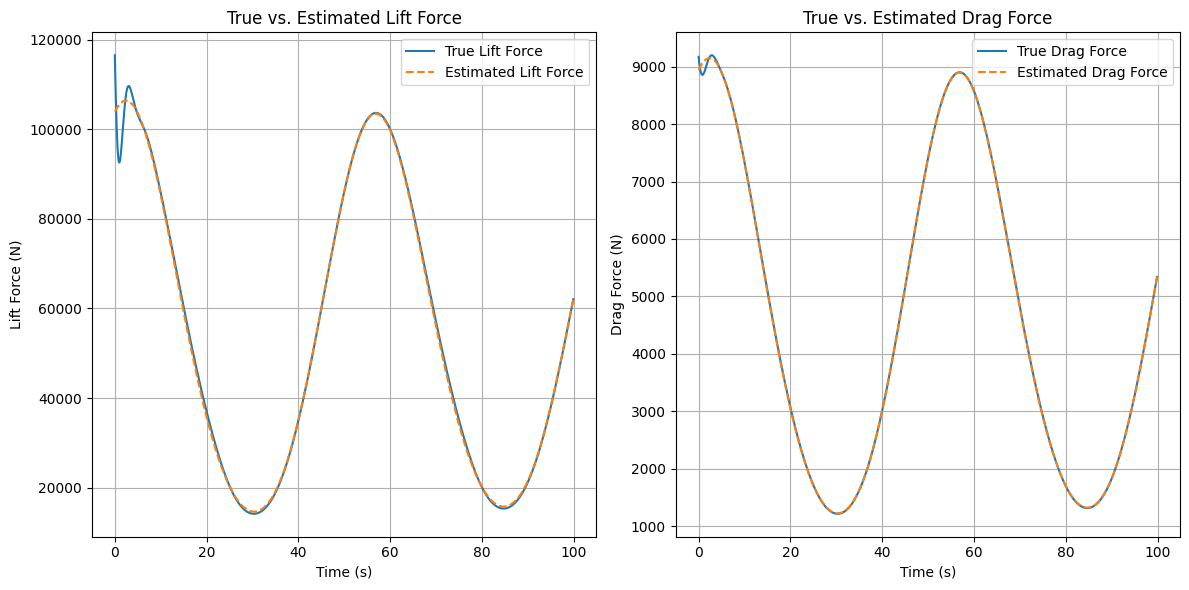

In [12]:
plt.figure(figsize=(12, 6))

# Lift comparison
plt.subplot(1, 2, 1)
plt.plot(time_array, Lift_true, label='True Lift Force')
plt.plot(time_array, Lift_estimated, linestyle='--', label='Estimated Lift Force')
plt.title('True vs. Estimated Lift Force')
plt.xlabel('Time (s)')
plt.ylabel('Lift Force (N)')
plt.legend()
plt.grid(True)

# Drag comparison
plt.subplot(1, 2, 2)
plt.plot(time_array, Drag_true, label='True Drag Force')
plt.plot(time_array, Drag_estimated, linestyle='--', label='Estimated Drag Force')
plt.title('True vs. Estimated Drag Force')
plt.xlabel('Time (s)')
plt.ylabel('Drag Force (N)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [13]:
Lift_error = Lift_true - Lift_estimated
Drag_error = Drag_true - Drag_estimated

# Error metrics
mae_lift = np.mean(np.abs(Lift_error))
rmse_lift = np.sqrt(np.mean(Lift_error**2))
mae_drag = np.mean(np.abs(Drag_error))
rmse_drag = np.sqrt(np.mean(Drag_error**2))

print(f"Lift Error: MAE = {mae_lift:.2f}, RMSE = {rmse_lift:.2f}")
print(f"Drag Error: MAE = {mae_drag:.2f}, RMSE = {rmse_drag:.2f}")

Lift Error: MAE = 660.31, RMSE = 1496.72
Drag Error: MAE = 11.49, RMSE = 25.32
